The purpose for this dataset is to be able to predict the classification of the animals, based upon the variables.

This dataset consists of 101 animals from a zoo.
There are 16 variables with various traits to describe the animals.
The 7 Class Types are: Mammal, Bird, Reptile, Fish, Amphibian, Bug and Invertebrate.

zoo.csv

Attribute Information: (name of attribute and type of value domain)

animal_name: Unique for each instance
hair Boolean
feathers Boolean
eggs Boolean
milk Boolean
airborne Boolean
aquatic Boolean
predator Boolean
toothed Boolean
backbone Boolean
breathes Boolean
venomous Boolean
fins Boolean
legs Numeric (set of values: {0,2,4,5,6,8})
tail Boolean
domestic Boolean
catsize Boolean
class_type Numeric (integer values in range [1,7])

class.csv

This csv describes the dataset

Class_Number Numeric (integer values in range [1,7])
Number_Of_Animal_Species_In_Class Numeric
Class_Type character -- The actual word description of the class
Animal_Names character -- The list of the animals that fall in the category of the class

In [1]:
import pandas as pd
import numpy as np
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import shap

c:\Users\wallemic\Documents\Robbie Deep Dive\MCW_personal-data-science-project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


See Files inside of Zip

In [2]:
zip_path = "Zoo Animal Dataset.zip"

# Open the ZIP file and check its contents

with zipfile.ZipFile(zip_path, "r") as z:
    print(z.namelist())  # Lists all files inside the ZIP

['class.csv', 'zoo.csv']


In [3]:
zoo_filename = "zoo.csv"  # Replace with actual file name
with zipfile.ZipFile(zip_path, "r") as z:
    with z.open(zoo_filename) as f:
        zoo_df = pd.read_csv(f)

# Display the first few rows
zoo_df

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


In [4]:
class_filename = "class.csv"  # Replace with actual file name
with zipfile.ZipFile(zip_path, "r") as z:
    with z.open(class_filename) as f:
        class_df = pd.read_csv(f)

# Display the first few rows
class_df.head()

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"


In [5]:
# Map class_type number to actual class name
class_mapping = class_df.set_index("Class_Number")["Class_Type"].to_dict()
zoo_df["class_name"] = zoo_df["class_type"].map(class_mapping)

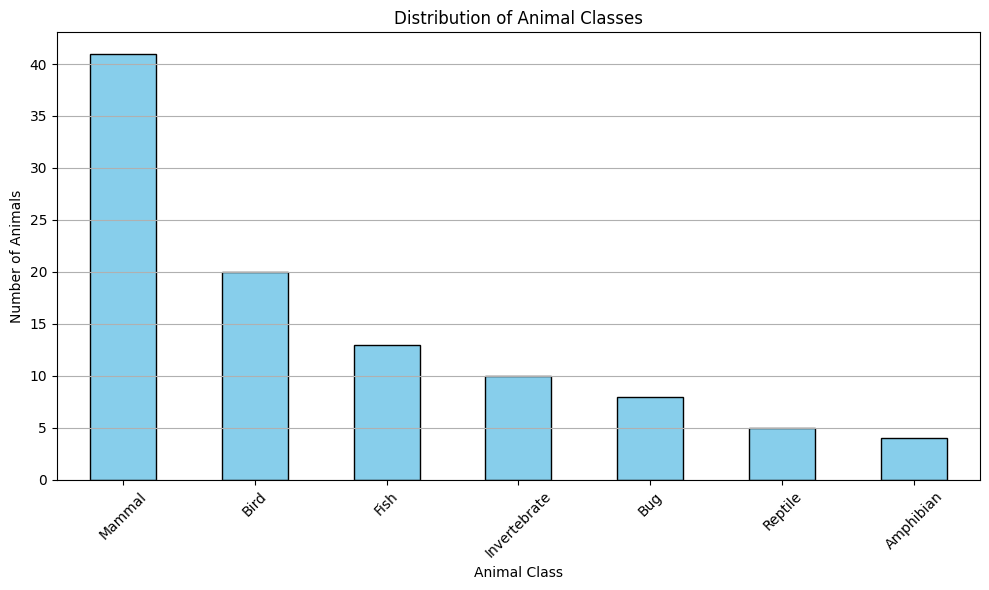

In [6]:
# Plot class distribution
plt.figure(figsize=(10, 6))
zoo_df["class_name"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Animal Classes")
plt.xlabel("Animal Class")
plt.ylabel("Number of Animals")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [7]:
missing_values = zoo_df.isnull().sum()

print(missing_values)

animal_name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
class_type     0
class_name     0
dtype: int64


In [8]:
zoo_df.shape

(101, 19)

In [9]:
zoo_df.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644,2.831683
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314,2.102709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,7.000000


`Unsure how best to handle the below? Some frogs are venomous while some are not`

In [10]:
# zoo_df[zoo_df.duplicated('animal_name', keep = False)].sort_values('animal_name')

In [11]:
fins_pivot = zoo_df.groupby(['fins','animal_name']).size().reset_index(name='count')

fins_pivot

,fins,animal_name,count
0,0,aardvark,1
1,0,antelope,1
2,0,bear,1
3,0,boar,1
4,0,buffalo,1
...,...,...,...
95,1,seal,1
96,1,sealion,1
97,1,sole,1
98,1,stingray,1


In [12]:
mammal_fins = zoo_df[(zoo_df['fins'] == 1 ) & (zoo_df['class_name'] == 'Mammal')]
                     
mammal_fins


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
19,dolphin,0,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,Mammal
66,porpoise,0,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,Mammal
74,seal,1,0,0,1,0,1,1,1,1,1,0,1,0,0,0,1,1,Mammal
75,sealion,1,0,0,1,0,1,1,1,1,1,0,1,2,1,0,1,1,Mammal


`When buliding a model do you modify the dataset to according to biological definitions or more common descriptions?`

Seals technically have tails but in this instance I will not modify the dataset. In this case we would reach out to the business for validation.

In [13]:
# zoo_df.loc[zoo_df['animal_name'] == 'seal', 'tail'] = 1

All Mammals have hair and provide milk to their young

In [14]:
zoo_df[zoo_df['class_name']== 'Mammal']

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,Mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1,Mammal
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,Mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1,Mammal
5,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1,Mammal
6,calf,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,1,1,Mammal
9,cavy,1,0,0,1,0,0,0,1,1,1,0,0,4,0,1,0,1,Mammal
10,cheetah,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1,Mammal
17,deer,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1,Mammal
19,dolphin,0,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,Mammal


In [15]:

zoo_df.loc[zoo_df['class_name']=='Mammal', ['hair','milk']] = 1

In [16]:
vampire = zoo_df[zoo_df['animal_name'] == 'vampire']
vampire

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
93,vampire,1,0,0,1,1,0,0,1,1,1,0,0,2,1,0,0,1,Mammal


In [17]:
zoo_df.loc[zoo_df['animal_name'] == 'vampire', 'predator'] = 1

In [18]:
tail_df = zoo_df[['animal_name','tail']]

In [19]:
eggs_df = zoo_df[['animal_name', 'eggs']]

In [20]:
tails_to_include = ['lobster','crayfish','bear','aardvark']
zoo_df.loc[zoo_df['animal_name'].isin(tails_to_include), 'tail'] = 1

In [21]:
milk_df = zoo_df[['animal_name', 'milk']]

The field called 'Legs' is the only numerical field with more than 2 values aside from info on Classes

Legs is the Number of Legs that an animal has not a binary flag

In [22]:
unique_counts = zoo_df.isnull().sum()
print(unique_counts)

animal_name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
class_type     0
class_name     0
dtype: int64


In [23]:
num_duplicates = zoo_df.duplicated().sum()

print(num_duplicates)

0


C:\Users\wallemic\AppData\Local\Temp\ipykernel_10784\3921483637.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=zoo_df, x='class_name', y='legs', palette='Set3')


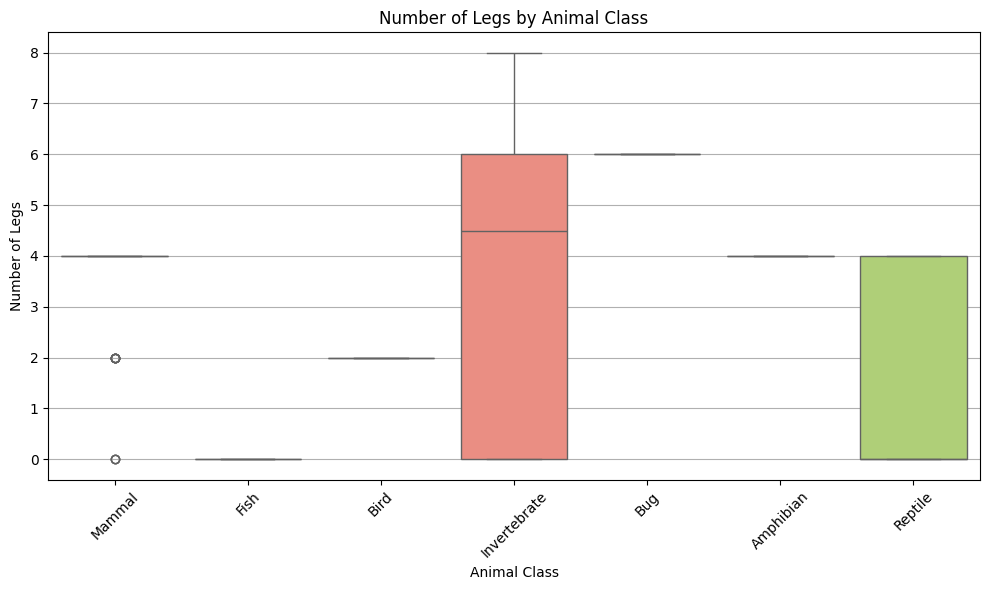

In [24]:
    # Create a boxplot of number of legs by class
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=zoo_df, x='class_name', y='legs', palette='Set3')
    plt.title('Number of Legs by Animal Class')
    plt.xlabel('Animal Class')
    plt.ylabel('Number of Legs')    
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [25]:
# no_breathe = zoo_df[zoo_df['breathes'] == 0]

# no_breathe

Suspicous here which Mamammals have 2 legs or 0 legs

In [26]:
non_fourleg_mam = zoo_df[(zoo_df['class_name'] == 'Mammal')& (zoo_df['legs'] < 4)]


# print(non_fourleg_mam[['animal_name', 'legs','class_name']] )

non_fourleg_mam

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
19,dolphin,1,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,Mammal
27,fruitbat,1,0,0,1,1,0,0,1,1,1,0,0,2,1,0,0,1,Mammal
29,girl,1,0,0,1,0,0,1,1,1,1,0,0,2,0,1,1,1,Mammal
32,gorilla,1,0,0,1,0,0,0,1,1,1,0,0,2,0,0,1,1,Mammal
66,porpoise,1,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,Mammal
74,seal,1,0,0,1,0,1,1,1,1,1,0,1,0,0,0,1,1,Mammal
75,sealion,1,0,0,1,0,1,1,1,1,1,0,1,2,1,0,1,1,Mammal
84,squirrel,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,0,1,Mammal
93,vampire,1,0,0,1,1,0,1,1,1,1,0,0,2,1,0,0,1,Mammal
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1,Mammal


`Modifying leg count on some animals as I believe that they are incorrect`

In [27]:
target_animal_changelegs = ['wallaby','vampire','squirrel','sealion','seal','gorilla','fruitbat']

zoo_df.loc[zoo_df['animal_name'].isin(target_animal_changelegs), 'legs'] = 4


In [28]:
mask = zoo_df['animal_name'].isin(target_animal_changelegs)

zoo_df_updated = zoo_df[mask]

print(zoo_df_updated[['animal_name', 'legs', 'class_name']].to_string(index=False))


animal_name  legs class_name
   fruitbat     4     Mammal
    gorilla     4     Mammal
       seal     4     Mammal
    sealion     4     Mammal
   squirrel     4     Mammal
    vampire     4     Mammal
    wallaby     4     Mammal


Scaling "Legs" feature as having 8 legs" isn’t 8x more important than "1 leg"
This should help improve training speed and convergence in some models.

StandardScaler will standardize values to: 


Mean = 0


Standard deviation = 1


In [29]:
scaler = StandardScaler()
zoo_df['legs']  = scaler.fit_transform(zoo_df[['legs']])

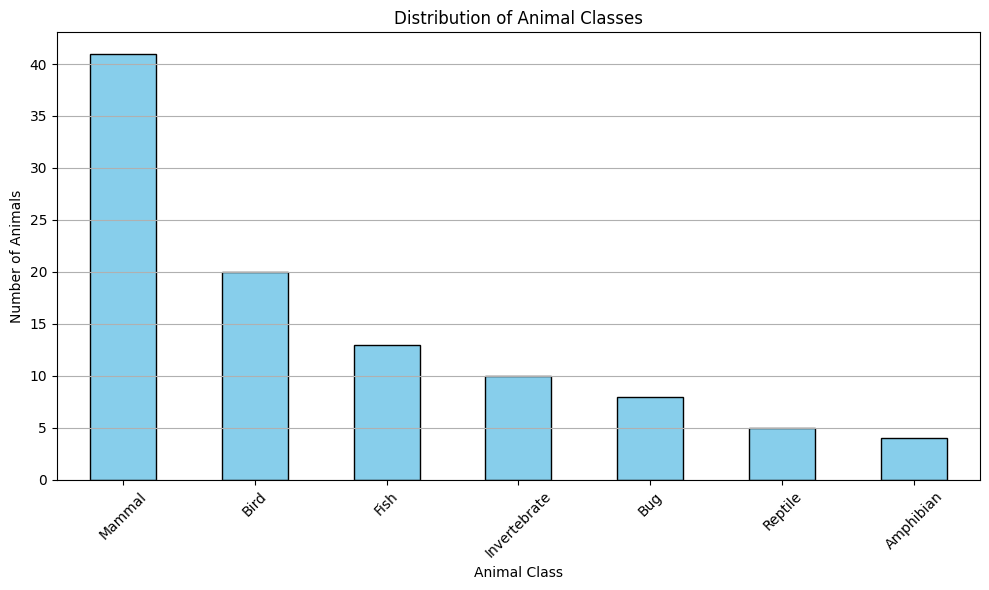

In [30]:
# Plot class distribution
plt.figure(figsize=(10, 6))
zoo_df["class_name"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Animal Classes")
plt.xlabel("Animal Class")
plt.ylabel("Number of Animals")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

Preprocessing

In [31]:
zoo_df

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1,Mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,0.497543,1,0,1,1,Mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,-1.492629,1,0,0,4,Fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1,Mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1,Mammal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,0.497543,1,0,1,1,Mammal
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,1.492629,0,0,0,6,Bug
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1,Mammal
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,-1.492629,0,0,0,7,Invertebrate


In [32]:
class_df

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


Drop Non Predictive Columns

In [33]:
df_model = zoo_df.drop(columns=['animal_name', 'class_name'])

df_model

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1
1,1,0,0,1,0,0,0,1,1,1,0,0,0.497543,1,0,1,1
2,0,0,1,0,0,1,1,1,1,0,0,1,-1.492629,1,0,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1
4,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,0,1,0,0,0,1,1,1,0,0,0.497543,1,0,1,1
97,1,0,1,0,1,0,0,0,0,1,1,0,1.492629,0,0,0,6
98,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1
99,0,0,1,0,0,0,0,0,0,1,0,0,-1.492629,0,0,0,7


Separate Features from Target

Training and Testing Splits with class stratificaiton

In [34]:
X = df_model.drop(columns = 'class_type')
y = df_model['class_type']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 22, stratify = y)


Using  StratifiedKFold for cross-validation technique since my target classes are imbalanced

Decision Tree will be my baseline model


In [35]:
param_grid = {
    'max_depth': [2, 4, 6, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state= 22)

grid = GridSearchCV(DecisionTreeClassifier(random_state=22), param_grid, cv = skf, scoring = 'accuracy')

grid.fit(X_train,y_train)

print("Best Parameters: ", grid.best_params_)
print("Best CV Score: ", grid.best_score_)

c:\Users\wallemic\Documents\Robbie Deep Dive\MCW_personal-data-science-project\venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters:  {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Best CV Score:  0.9625


In [36]:
sorted_labels = sorted(y_test.unique())
sorted_labels

[np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7)]

In [37]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

labels=[1,2,3,4,5,6,7]
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels = labels)
report = classification_report(y_test, y_pred)

print("Accuracy: ", acc)
print("Classificaiton Report:  \n", report)
print("Confusion Matrix: ", cm)


Accuracy:  0.9523809523809523
Classificaiton Report:  
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2

    accuracy                           0.95        21
   macro avg       0.81      0.86      0.83        21
weighted avg       0.92      0.95      0.93        21

Confusion Matrix:  [[8 0 0 0 0 0 0]
 [0 4 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 2]]


c:\Users\wallemic\Documents\Robbie Deep Dive\MCW_personal-data-science-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wallemic\Documents\Robbie Deep Dive\MCW_personal-data-science-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wallemic\Documents\Robbie Deep Dive\MCW_personal-data-science-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

In [38]:
results_df = X_test.copy()
results_df['true_label'] = y_test.values
results_df['predicted_label'] = y_pred

missclassified = results_df[results_df['true_label'] != results_df['predicted_label']]

missclassified

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,true_label,predicted_label
90,0,0,1,0,0,0,0,0,1,1,0,0,0.497543,1,0,1,3,6


In [39]:
zoo_df

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1,Mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,0.497543,1,0,1,1,Mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,-1.492629,1,0,0,4,Fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1,Mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1,Mammal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,0.497543,1,0,1,1,Mammal
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,1.492629,0,0,0,6,Bug
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,0.497543,1,0,1,1,Mammal
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,-1.492629,0,0,0,7,Invertebrate


In [40]:
zoo_df.columns

Index(['animal_name', 'hair', 'feathers', 'eggs', 'milk', 'airborne',
       'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous',
       'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type',
       'class_name'],
      dtype='object')

In [41]:
zoo_df[zoo_df["class_name"] == 'Reptile']

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
62,pitviper,0,0,1,0,0,0,1,1,1,1,1,0,-1.492629,1,0,0,3,Reptile
76,seasnake,0,0,0,0,0,1,1,1,1,0,1,0,-1.492629,1,0,0,3,Reptile
80,slowworm,0,0,1,0,0,0,1,1,1,1,0,0,-1.492629,1,0,0,3,Reptile
90,tortoise,0,0,1,0,0,0,0,0,1,1,0,0,0.497543,1,0,1,3,Reptile
91,tuatara,0,0,1,0,0,0,1,1,1,1,0,0,0.497543,1,0,0,3,Reptile


In [42]:
zoo_df[zoo_df['class_name'] == 'Bug']

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
24,flea,0,0,1,0,0,0,0,0,0,1,0,0,1.492629,0,0,0,6,Bug
30,gnat,0,0,1,0,1,0,0,0,0,1,0,0,1.492629,0,0,0,6,Bug
39,honeybee,1,0,1,0,1,0,0,0,0,1,1,0,1.492629,0,1,0,6,Bug
40,housefly,1,0,1,0,1,0,0,0,0,1,0,0,1.492629,0,0,0,6,Bug
42,ladybird,0,0,1,0,1,0,1,0,0,1,0,0,1.492629,0,0,0,6,Bug
51,moth,1,0,1,0,1,0,0,0,0,1,0,0,1.492629,0,0,0,6,Bug
88,termite,0,0,1,0,0,0,0,0,0,1,0,0,1.492629,0,0,0,6,Bug
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,1.492629,0,0,0,6,Bug


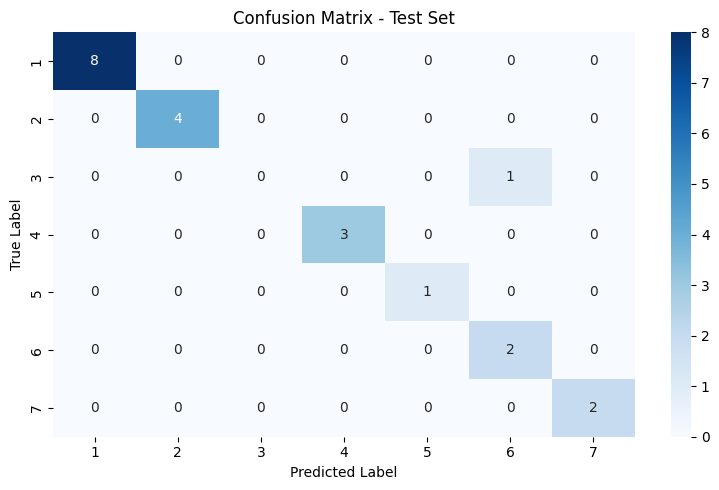

In [44]:
labels = sorted(y_test.unique())

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Modelling Classifiers: Decision Tree & Random Forrest